In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

In [3]:
BASE_PATH = "/mnt/Data/data"
base_dir = Path(BASE_PATH).resolve()

In [4]:
config = {
    "config_folder": "../data/mearec",
    "recordings_folder": str(base_dir / "output/recordings"),
    "templates_folder": str(base_dir / "output/templates")
}

In [5]:
from eapprocessor.mearec.api import generate_templates, generate_recordings, load_recordings

In [6]:
fs_list = [24000, 20000, 16000]
noise_levels = [5, 10, 15, 25]

In [7]:
all_recgen_list = [[load_recordings(datafolder=config["recordings_folder"],
                verbose=True, noise_level=noise_level, fs=fs) for noise_level in noise_levels]
               for fs in fs_list]

Found file /mnt/Data/data/output/recordings/recordings_10cells_Neuronexus-32_10.0_5uV_24000Hz_2021-12-02_10-59.h5
Loading recordings...
Done loading recordings...
Found file /mnt/Data/data/output/recordings/recordings_10cells_Neuronexus-32_10.0_10uV_24000Hz_2021-12-02_11-00.h5
Loading recordings...
Done loading recordings...
Found file /mnt/Data/data/output/recordings/recordings_10cells_Neuronexus-32_10.0_15uV_24000Hz_2021-12-02_11-00.h5
Loading recordings...
Done loading recordings...
Found file /mnt/Data/data/output/recordings/recordings_10cells_Neuronexus-32_10.0_25uV_24000Hz_2021-12-02_11-00.h5
Loading recordings...
Done loading recordings...
Found file /mnt/Data/data/output/recordings/recordings_10cells_Neuronexus-32_10.0_5uV_20000Hz_2021-12-02_11-00.h5
Loading recordings...
Done loading recordings...
Found file /mnt/Data/data/output/recordings/recordings_10cells_Neuronexus-32_10.0_10uV_20000Hz_2021-12-02_11-00.h5
Loading recordings...
Done loading recordings...
Found file /mnt/Da

In [8]:
channel_indexes=[21,27]
nthresholds = 50

In [9]:
recordings_20khz = all_recgen_list[1]
recgen=recordings_20khz[0]

In [10]:
from eapprocessor.plot.signals import plot_transient_recordings

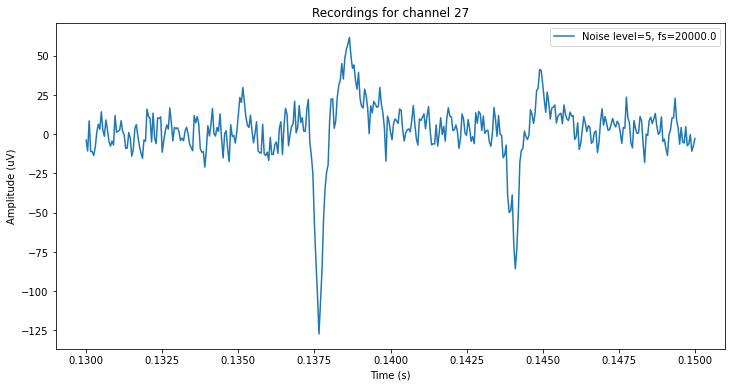

In [11]:
plot_transient_recordings(recgen, channels=[channel_indexes[1]], t_start=130e-3, t_stop=150e-3)

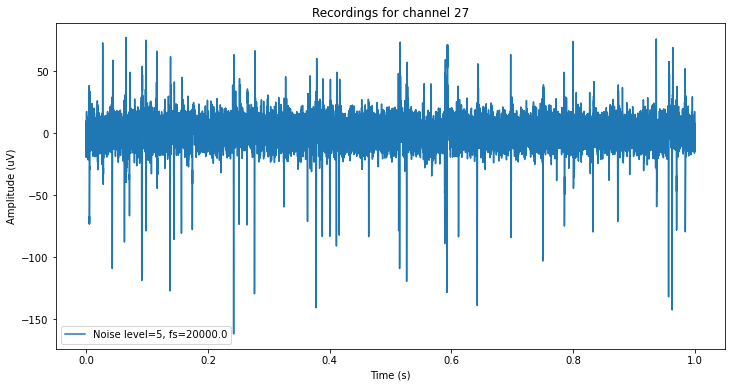

In [25]:
plot_transient_recordings(recgen, channels=[channel_indexes[1]], t_start=0, t_stop=1)

In [13]:
import numpy as np

In [14]:
recordings = recgen.recordings[:].T
timestamps = np.array(recgen.timestamps)

In [15]:
selected = recordings[channel_indexes[1]]

In [16]:
import pandas as pd

In [110]:
df = pd.DataFrame({"time":timestamps,"vout":selected})

In [111]:
tolerance= 2

In [112]:
df["within_tolerance"] = (np.abs(df["vout"]) <=tolerance)*1
df["within_p1"]=df["within_tolerance"].shift(periods=1, fill_value=0)
df["within_m1"]=df["within_tolerance"].shift(periods=-1, fill_value=0)
df["within_interval"] = df["within_tolerance"] * df["within_p1"] * df["within_m1"]

In [113]:
breakpoints = np.arange(1,10,1)

In [134]:
def get_breakpoint_interval(df, t_start,t_stop):
    seldf = df.loc[(df["time"]>=t_start) & (df["time"]<=t_stop)].copy()
    return seldf["within_interval"].loc[seldf["within_interval"]==1].index

def get_breakpoint_tolerance(df, breakpoint, tolerance):
    result=[]
    scale=1
    while(len(result)<1):
        print(f"scale:{scale}")
        t_start=breakpoint - tolerance*scale
        t_stop=breakpoint + tolerance*scale
        result = get_breakpoint_interval(df, t_start, t_stop)
        scale=scale*2
    return result[0]

In [136]:
n_breaks = [get_breakpoint_tolerance(df,breakpoint,5e-3) for breakpoint in breakpoints ]

scale:1
scale:1
scale:1
scale:2
scale:1
scale:1
scale:1
scale:1
scale:2
scale:4
scale:1
scale:1


In [157]:
n_breaks

[19982, 39979, 59873, 79974, 99914, 119995, 139756, 160047, 179914]

In [171]:
def get_chunks(df, indexes):
    index_l = 0
    chunks = []
    for index in indexes:
        index_h = index
        chunks.append(df.iloc[index_l:index_h].copy())
        index_l = index+1
    chunks.append(df.iloc[index_l:].copy())
    return chunks

In [179]:
chunks = get_chunks(df, n_breaks)
chunks

[          time       vout  within_tolerance  within_p1  within_m1  \
 0      0.00000   2.311063                 0          0          0   
 1      0.00005   9.914375                 0          0          1   
 2      0.00010   1.843763                 1          0          0   
 3      0.00015 -19.521925                 0          1          0   
 4      0.00020 -14.735105                 0          0          0   
 ...        ...        ...               ...        ...        ...   
 19977  0.99885   7.605921                 0          0          0   
 19978  0.99890  -8.800547                 0          0          0   
 19979  0.99895   3.703901                 0          0          0   
 19980  0.99900   3.645284                 0          0          1   
 19981  0.99905  -0.872535                 1          0          1   
 
        within_interval  
 0                    0  
 1                    0  
 2                    0  
 3                    0  
 4                    0  
 .

In [180]:
def adapt_df(df, scale=1e-6):
    df["time"] = df["time"]-np.array(df["time"])[0]
    df["vout"] = df["vout"]*1e-6
    return df[["time","vout"]].copy()

In [181]:
chunks = [adapt_df(chunk) for chunk in chunks]

In [204]:
end_times = [np.array(chunk["time"])[-1] for chunk in chunks]
end_times

[0.99905,
 0.9997499999999999,
 0.9945999999999997,
 1.00495,
 0.9969000000000006,
 1.0039499999999997,
 0.9879500000000005,
 1.01445,
 0.9932499999999997,
 1.0042000000000009]

In [191]:
folder = Path("/mnt/Archivos/Nextcloud/MaestriaPUCP/Thesis/development/project/data")
filename = "recordings_20khz_5u.csv"
filepath = folder / filename

In [192]:
from eapprocessor.tools.export import export_to_csv

In [202]:
for i, chunk in enumerate(chunks):
    chunk_file = filepath.parent /  f"{filepath.stem}_{i}{filepath.suffix}"
    export_to_csv(chunk, chunk_file)

In [203]:
!ls -lah /mnt/Archivos/Nextcloud/MaestriaPUCP/Thesis/development/project/data

total 6.0M
drwxr-xr-x 1 luighi users  320 Aug  6 19:25 .
drwxr-xr-x 1 luighi users 8.0K Jul 31 01:18 ..
-rw-r--r-- 1 luighi users 421K Aug  6 19:25 recordings_20khz_5u_0.csv
-rw-r--r-- 1 luighi users 578K Aug  6 19:25 recordings_20khz_5u_1.csv
-rw-r--r-- 1 luighi users 612K Aug  6 19:25 recordings_20khz_5u_2.csv
-rw-r--r-- 1 luighi users 619K Aug  6 19:25 recordings_20khz_5u_3.csv
-rw-r--r-- 1 luighi users 633K Aug  6 19:25 recordings_20khz_5u_4.csv
-rw-r--r-- 1 luighi users 637K Aug  6 19:25 recordings_20khz_5u_5.csv
-rw-r--r-- 1 luighi users 632K Aug  6 19:25 recordings_20khz_5u_6.csv
-rw-r--r-- 1 luighi users 643K Aug  6 19:25 recordings_20khz_5u_7.csv
-rw-r--r-- 1 luighi users 640K Aug  6 19:25 recordings_20khz_5u_8.csv
-rw-r--r-- 1 luighi users 646K Aug  6 19:25 recordings_20khz_5u_9.csv
